<a href="https://colab.research.google.com/github/gulierus/VU_RG/blob/main/P%C5%99%C3%ADklady_ML_Type_II_a_NUTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# NUTS sampling
try:
    import pymc as pm
    import pytensor.tensor as pt
    PYMC_AVAILABLE = True
except ImportError:
    PYMC_AVAILABLE = False
    print("PyMC není nainstalován - NUTS experiment bude přeskočen")
    print("Pro instalaci: pip install pymc")


In [ ]:
def plot_gp_results(X_train, y_train, X_test, y_test, predictions, title):

    plt.figure(figsize=(12, 5))

    sort_idx = np.argsort(X_test.flatten())
    X_test_sorted = X_test[sort_idx]
    y_test_sorted = y_test[sort_idx]
    mean_sorted = predictions['mean'][sort_idx]
    std_sorted = predictions['std'][sort_idx]

    # Graf
    plt.plot(X_test_sorted, y_test_sorted, 'r-', label='Skutečná funkce', linewidth=2)
    plt.plot(X_test_sorted, mean_sorted, 'b-', label='GP predikce', linewidth=2)
    plt.fill_between(X_test_sorted.flatten(),
                     mean_sorted - 2*std_sorted,
                     mean_sorted + 2*std_sorted,
                     alpha=0.3, label='95% confidence interval')
    plt.scatter(X_train, y_train, c='black', s=50, label='Trénovací data', zorder=5)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

Trénování dokončeno za 4.6777 sekund

Optimalizované hyperparametry:
  0.68**2 * RBF(length_scale=0.219) + WhiteKernel(noise_level=0.00867)

Log marginal likelihood: 31.6272

Predikce a vyhodnocení
------------------------------------------------------------
Predikce dokončena za 0.0147 sekund
Mean Squared Error: 0.000924
Průměrná uncertainty (std): 0.0999


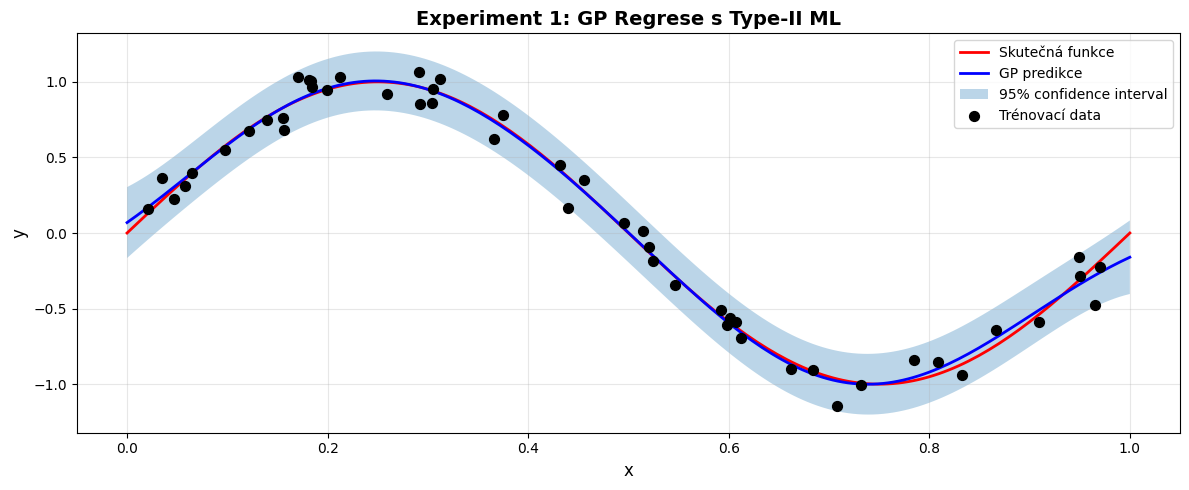

In [ ]:
# Type II ML odhad

# Generování syntetických dat
np.random.seed(42)
n_train = 50
n_test = 200

# Body generujeme ze sinusovky
X_train_gp = np.random.uniform(0, 1, n_train).reshape(-1, 1)
noise_std = 0.1
y_train_gp = np.sin(2 * np.pi * X_train_gp).flatten() + np.random.normal(0, noise_std, n_train)

X_test_gp = np.linspace(0, 1, n_test).reshape(-1, 1)
y_test_gp = np.sin(2 * np.pi * X_test_gp).flatten()

kernel_gp = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

gp_classical = GaussianProcessRegressor(
                                        kernel=kernel_gp,
                                        n_restarts_optimizer=10,
                                        random_state=42
                                       )
print("=" * 60)
start_time = time.time()
gp_classical.fit(X_train_gp, y_train_gp)
train_time_gp = time.time() - start_time

print("=" * 60)
print(f"Trénování dokončeno za {train_time_gp:.4f} sekund")
print(f"\nOptimalizované hyperparametry:")
print(f"  {gp_classical.kernel_}")
print(f"\nLog marginal likelihood: {gp_classical.log_marginal_likelihood_value_:.4f}")

print("=" * 60)
print("\nPredikce a vyhodnocení")
print("-" * 60)
start_time = time.time()
y_pred_gp, y_std_gp = gp_classical.predict(X_test_gp, return_std=True)
inference_time_gp = time.time() - start_time

mse_gp = mean_squared_error(y_test_gp, y_pred_gp)
print(f"Predikce dokončena za {inference_time_gp:.4f} sekund")
print(f"Mean Squared Error: {mse_gp:.6f}")
print(f"Průměrná uncertainty (std): {np.mean(y_std_gp):.4f}")

fig1 = plot_gp_results(
    X_train_gp, y_train_gp, X_test_gp, y_test_gp,
    {'mean': y_pred_gp, 'std': y_std_gp},
    'Experiment 1: GP Regrese s Type-II ML'
)




Vizualizace konvergence k ML odhadu


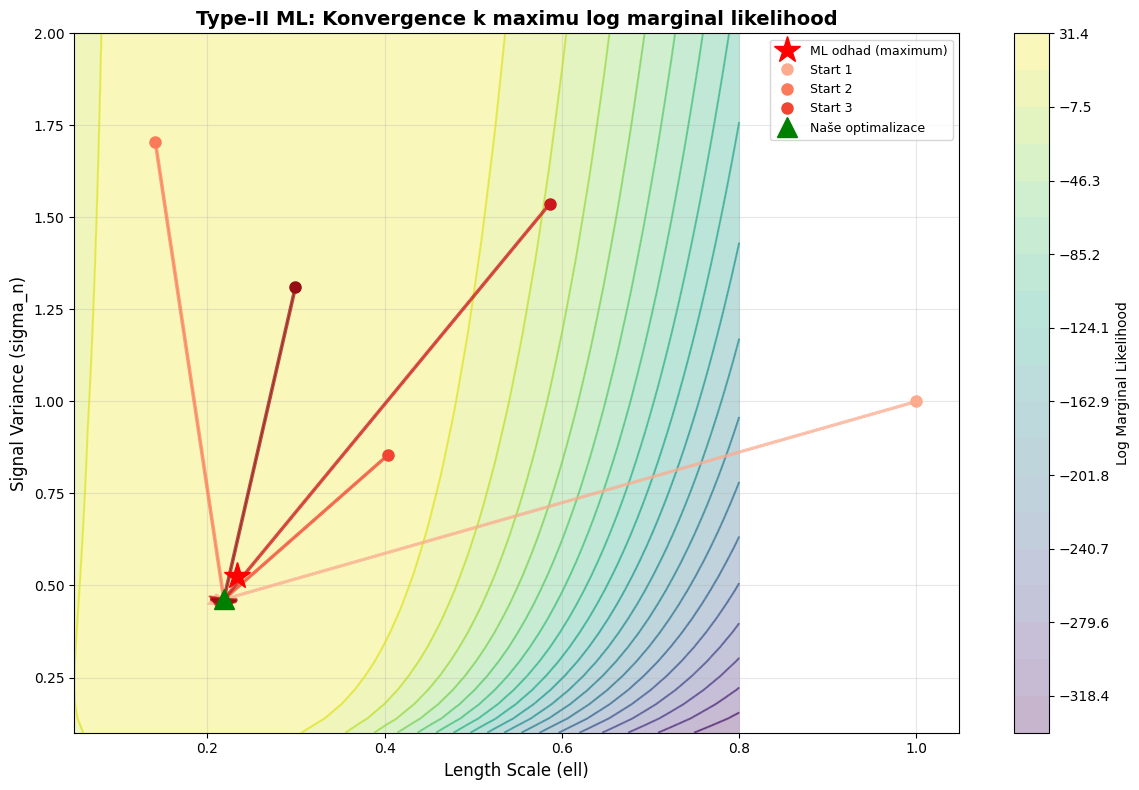

In [ ]:
# Vizualizace konvergence k ML odhadu
print("=" * 60)
print("Vizualizace konvergence k ML odhadu")
print("=" * 60)

# Vytvoříme grid pro vizualizaci log marginal likelihood
length_scales = np.linspace(0.05, 0.8, 50)
signal_vars = np.linspace(0.1, 2.0, 50)
LS, SV = np.meshgrid(length_scales, signal_vars)

# Spočítáme log marginal likelihood pro každou kombinaci
log_likelihoods = np.zeros_like(LS)
for i in range(LS.shape[0]):
    for j in range(LS.shape[1]):
        kernel_temp = ConstantKernel(SV[i,j]) * RBF(length_scale=LS[i,j]) + \
                      WhiteKernel(noise_level=0.01)  # fixní noise pro vizualizaci
        gp_temp = GaussianProcessRegressor(kernel=kernel_temp, optimizer=None)
        gp_temp.fit(X_train_gp, y_train_gp)
        log_likelihoods[i,j] = gp_temp.log_marginal_likelihood_value_

# Simulujeme trajektorii optimalizace (několik restartů)

trajectories = []
for restart in range(5):
    # Různé startovní body
    if restart == 0:
        init_ls, init_sv = 1.0, 1.0  # Default
    else:
        init_ls = np.random.uniform(0.1, 0.7)
        init_sv = np.random.uniform(0.2, 1.8)

    kernel_init = ConstantKernel(init_sv) * RBF(length_scale=init_ls) + \
                  WhiteKernel(noise_level=0.01)
    gp_temp = GaussianProcessRegressor(kernel=kernel_init, n_restarts_optimizer=0,
                                       random_state=restart)
    gp_temp.fit(X_train_gp, y_train_gp)

    # Extrahujeme optimalizované parametry
    params = gp_temp.kernel_.get_params()
    final_ls = params['k1__k2__length_scale']
    final_sv = params['k1__k1__constant_value']

    trajectories.append({
        'start': (init_ls, init_sv),
        'end': (final_ls, final_sv)
    })

# Vytvoříme vizualizaci
fig2, ax = plt.subplots(figsize=(12, 8))

# Contour plot log marginal likelihood
levels = np.linspace(log_likelihoods.min(), log_likelihoods.max(), 20)
contour = ax.contour(LS, SV, log_likelihoods, levels=levels, cmap='viridis', alpha=0.6)
contourf = ax.contourf(LS, SV, log_likelihoods, levels=levels, cmap='viridis', alpha=0.3)
cbar = plt.colorbar(contourf, ax=ax, label='Log Marginal Likelihood')

# Najdeme maximum
max_idx = np.unravel_index(log_likelihoods.argmax(), log_likelihoods.shape)
max_ls = LS[max_idx]
max_sv = SV[max_idx]

# Označíme maximum
ax.plot(max_ls, max_sv, 'r*', markersize=20, label='ML odhad (maximum)', zorder=10)

# Vykreslíme trajektorie
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(trajectories)))
for i, traj in enumerate(trajectories):
    ax.arrow(traj['start'][0], traj['start'][1],
             traj['end'][0] - traj['start'][0],
             traj['end'][1] - traj['start'][1],
             head_width=0.03, head_length=0.02, fc=colors[i], ec=colors[i],
             linewidth=2, alpha=0.7, zorder=5)
    ax.plot(traj['start'][0], traj['start'][1], 'o', color=colors[i],
            markersize=8, label=f'Start {i+1}' if i < 3 else '')

# Optimalizované hodnoty z našeho modelu
final_params = gp_classical.kernel_.get_params()
opt_ls = final_params['k1__k2__length_scale']
opt_sv = final_params['k1__k1__constant_value']
ax.plot(opt_ls, opt_sv, 'g^', markersize=15, label='Naše optimalizace', zorder=10)

ax.set_xlabel('Length Scale (ell)', fontsize=12)
ax.set_ylabel('Signal Variance (sigma_n)', fontsize=12)
ax.set_title('Type-II ML: Konvergence k maximu log marginal likelihood',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()

NUTS - Plná Bayesian inference přes hyperparametry


Output()


NUTS sampling dokončen za 19.10 sekund

Diagnostika MCMC
Posterior summary:
          mean     sd  hdi_3%  hdi_97%  r_hat
ell      0.293  0.069   0.169    0.413   1.01
eta      1.257  0.647   0.399    2.406   1.01
sigma_n  0.097  0.010   0.077    0.113   1.00

Počet posterior samples: 1000
Length scale: 0.2931 ± 0.0686
Signal std:   1.2570 ± 0.6465
Noise std:    0.0966 ± 0.0103

 Predikce pomocí posterior samples
Predikce dokončena za 1.9455 sekund
   (použito 500 posterior samples)
Mean Squared Error: 0.000597
Průměrná uncertainty (std): 0.0091


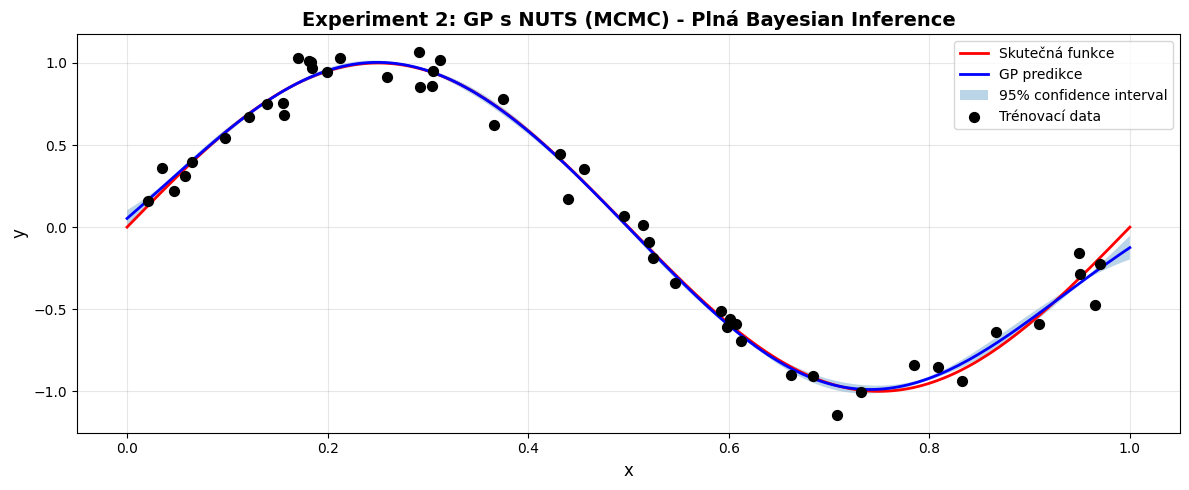

In [ ]:
#NUTS (MCMC) odhad

if PYMC_AVAILABLE:
    print("NUTS - Plná Bayesian inference přes hyperparametry")
    print("=" * 60)

    # Definice GP modelu v PyMC
    print("=" * 60)

    # Použijeme stejná data jako v Experimentu 1
    X_train_nuts = X_train_gp.flatten()
    y_train_nuts = y_train_gp
    X_test_nuts = X_test_gp.flatten()

    with pm.Model() as gp_nuts_model:
        # Hyper-priory pro hyperparametry (širší než v Type-II ML)
        # Length scale - log-normal prior
        ell = pm.Gamma("ell", alpha=2, beta=1)  # Prior pro length scale

        # Signal variance - log-normal prior
        eta = pm.HalfNormal("eta", sigma=2.0)  # Signal std deviation

        # Noise variance
        sigma_n = pm.HalfNormal("sigma_n", sigma=0.5)  # Noise std deviation

        # Squared exponential (RBF) covariance function
        cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

        # GP prior
        gp = pm.gp.Marginal(cov_func=cov_func)

        # Likelihood - pozorovaná data
        y_obs = gp.marginal_likelihood("y_obs", X=X_train_nuts[:, None],
                                       y=y_train_nuts, sigma=sigma_n)



    with gp_nuts_model:
        start_time = time.time()

        # NUTS sampling
        # draws: počet samples po warmup
        # tune: počet warmup samples (vyhozen)
        # chains: počet paralelních MCMC řetězců
        trace = pm.sample(
            draws=500,           # 500 posterior samples
            tune=500,            # 500 warmup samples
            chains=2,            # 2 řetězce pro diagnostiku
            random_seed=42,
            progressbar=True,
            return_inferencedata=True
        )

        nuts_sample_time = time.time() - start_time

    print("=" * 60)
    print(f"\nNUTS sampling dokončen za {nuts_sample_time:.2f} sekund")

    print("\nDiagnostika MCMC")
    print("=" * 60)

    # R-hat statistika (mělo by být ~1.0)
    summary = pm.summary(trace, var_names=["ell", "eta", "sigma_n"])
    print("Posterior summary:")
    print(summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat']])

    # Extrakce posterior samples
    posterior = trace.posterior
    ell_samples = posterior["ell"].values.flatten()
    eta_samples = posterior["eta"].values.flatten()
    sigma_n_samples = posterior["sigma_n"].values.flatten()

    print(f"\nPočet posterior samples: {len(ell_samples)}")
    print(f"Length scale: {ell_samples.mean():.4f} ± {ell_samples.std():.4f}")
    print(f"Signal std:   {eta_samples.mean():.4f} ± {eta_samples.std():.4f}")
    print(f"Noise std:    {sigma_n_samples.mean():.4f} ± {sigma_n_samples.std():.4f}")

    print("\n Predikce pomocí posterior samples")
    print("=" * 60)
    # Pro každý sample hyperparametrů θ_s děláme GP predikci
    # PPD = průměr přes všechny predikce

    start_time = time.time()

    # Pro každý posterior sample uděláme predikci
    n_pred_samples = min(500, len(ell_samples))  # Použijeme 100 samples
    indices = np.random.choice(len(ell_samples), n_pred_samples, replace=False)

    predictions_nuts = []

    for idx in indices:
        # GP s hyperparametry z tohoto sample
        ell_s = ell_samples[idx]
        eta_s = eta_samples[idx]
        sigma_n_s = sigma_n_samples[idx]

        # Kernel s těmito hyperparametry
        kernel_s = eta_s**2 * RBF(length_scale=ell_s) + WhiteKernel(noise_level=sigma_n_s**2)

        # GP regressor s fixními hyperparametry
        gp_s = GaussianProcessRegressor(kernel=kernel_s, optimizer=None)
        gp_s.fit(X_train_gp, y_train_gp)

        # Predikce
        y_pred_s, y_std_s = gp_s.predict(X_test_gp, return_std=True)
        predictions_nuts.append(y_pred_s)

    # PPD = průměr přes všechny predikce
    y_pred_nuts = np.mean(predictions_nuts, axis=0)
    y_std_nuts = np.std(predictions_nuts, axis=0)  # Posterior predictive uncertainty

    nuts_inference_time = time.time() - start_time

    mse_nuts = mean_squared_error(y_test_gp, y_pred_nuts)

    print(f"Predikce dokončena za {nuts_inference_time:.4f} sekund")
    print(f"   (použito {n_pred_samples} posterior samples)")
    print(f"Mean Squared Error: {mse_nuts:.6f}")
    print(f"Průměrná uncertainty (std): {np.mean(y_std_nuts):.4f}")

    # Vizualizace
    fig2 = plot_gp_results(
        X_train_gp, y_train_gp, X_test_gp, y_test_gp,
        {'mean': y_pred_nuts, 'std': y_std_nuts},
        'Experiment 2: GP s NUTS (MCMC) - Plná Bayesian Inference'
    )

else:
    print("\nPyMC není k dispozici - NUTS experiment přeskočen")
    print("Pro instalaci: pip install pymc")

Vytváříme trace plots, posterior distribuce a pair plot...


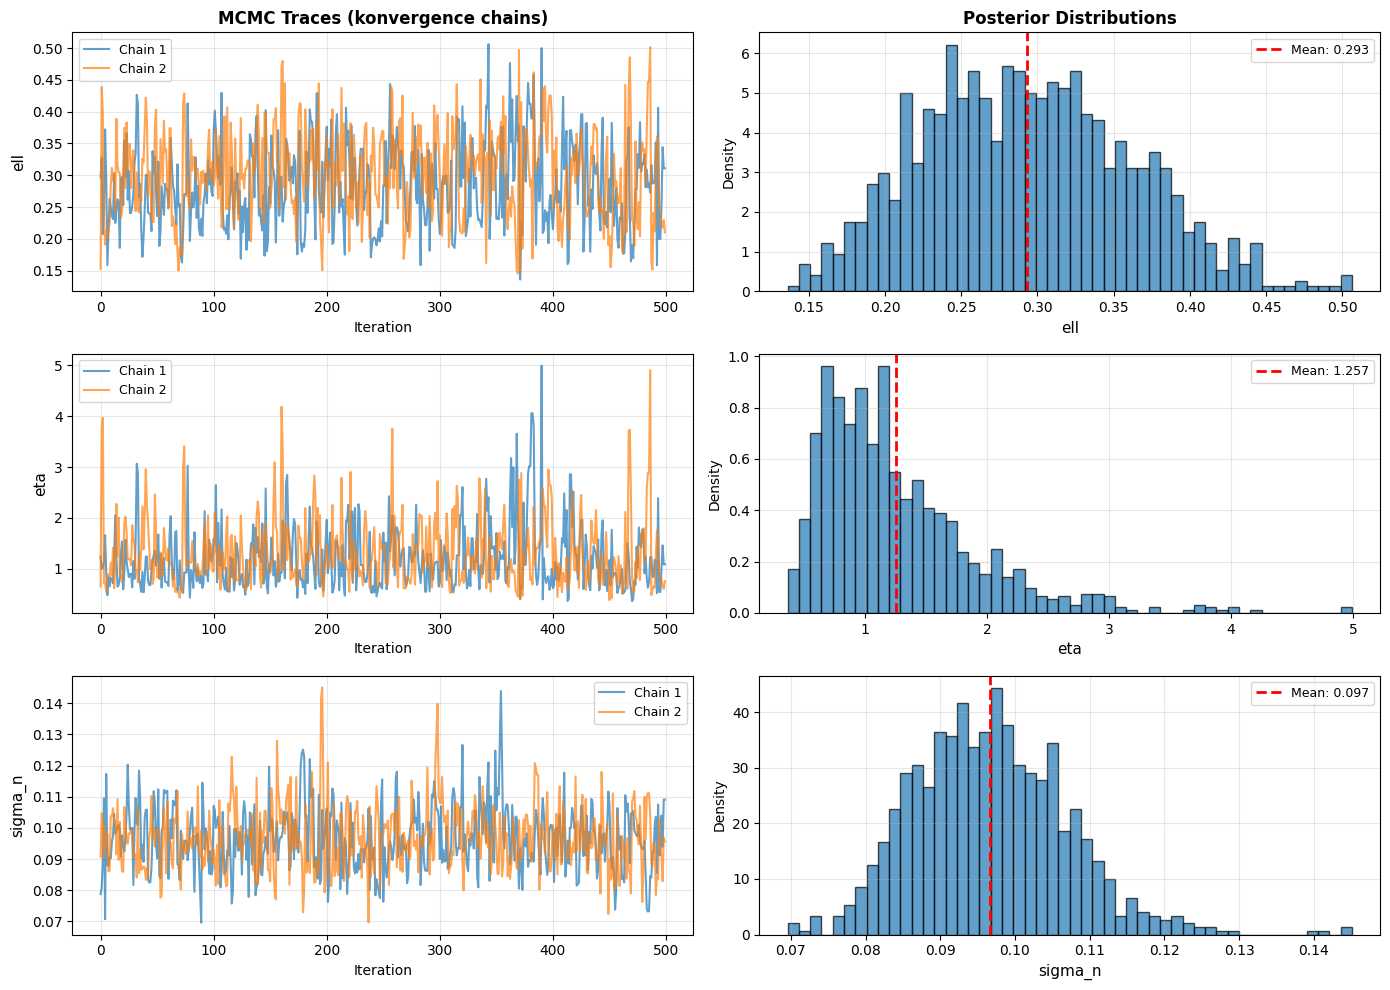

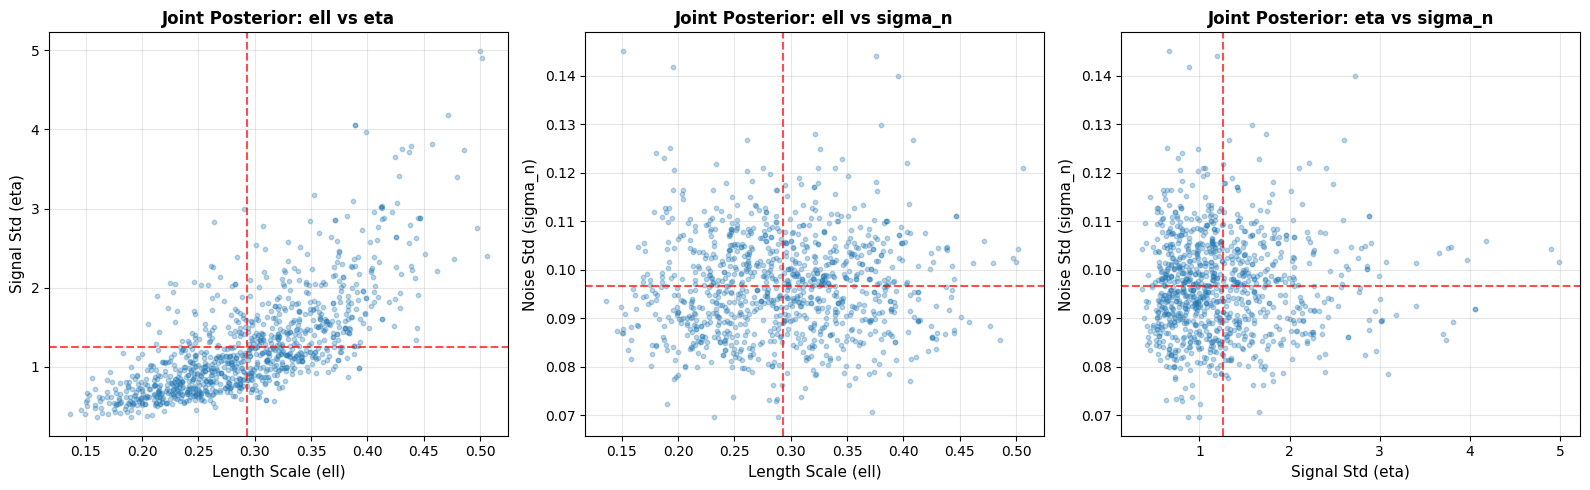

In [ ]:
# Vizualizace NUTS sampling

print("=" * 60)
print("Vytváříme trace plots, posterior distribuce a pair plot...")

# Trace plots - ukazují konvergenci chains
fig4, axes = plt.subplots(3, 2, figsize=(14, 10))

params_names = ['ell', 'eta', 'sigma_n']
params_samples = [ell_samples, eta_samples, sigma_n_samples]

for i, (name, samples) in enumerate(zip(params_names, params_samples)):
    # Rozdělíme samples na 2 chains
    samples_reshaped = samples.reshape(2, -1)

    # Trace plot (vlevo)
    ax_trace = axes[i, 0]
    for chain_idx in range(2):
        ax_trace.plot(samples_reshaped[chain_idx], alpha=0.7,
                     label=f'Chain {chain_idx+1}')
    ax_trace.set_ylabel(name, fontsize=11)
    ax_trace.set_xlabel('Iteration', fontsize=10)
    ax_trace.legend(fontsize=9)
    ax_trace.grid(alpha=0.3)
    if i == 0:
        ax_trace.set_title('MCMC Traces (konvergence chains)', fontsize=12, fontweight='bold')

    # Posterior histogram (vpravo)
    ax_hist = axes[i, 1]
    ax_hist.hist(samples, bins=50, alpha=0.7, edgecolor='black', density=True)
    ax_hist.axvline(samples.mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {samples.mean():.3f}')
    ax_hist.set_xlabel(name, fontsize=11)
    ax_hist.set_ylabel('Density', fontsize=10)
    ax_hist.legend(fontsize=9)
    ax_hist.grid(alpha=0.3)
    if i == 0:
        ax_hist.set_title('Posterior Distributions', fontsize=12, fontweight='bold')

plt.tight_layout()

# Joint posterior (2D scatter)
fig5, axes = plt.subplots(1, 3, figsize=(16, 5))

# ℓ vs η
axes[0].scatter(ell_samples, eta_samples, alpha=0.3, s=10)
axes[0].axvline(ell_samples.mean(), color='red', linestyle='--', alpha=0.7)
axes[0].axhline(eta_samples.mean(), color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Length Scale (ell)', fontsize=11)
axes[0].set_ylabel('Signal Std (eta)', fontsize=11)
axes[0].set_title('Joint Posterior: ell vs eta', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# ℓ vs σ_n
axes[1].scatter(ell_samples, sigma_n_samples, alpha=0.3, s=10)
axes[1].axvline(ell_samples.mean(), color='red', linestyle='--', alpha=0.7)
axes[1].axhline(sigma_n_samples.mean(), color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Length Scale (ell)', fontsize=11)
axes[1].set_ylabel('Noise Std (sigma_n)', fontsize=11)
axes[1].set_title('Joint Posterior: ell vs sigma_n', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# η vs σ_n
axes[2].scatter(eta_samples, sigma_n_samples, alpha=0.3, s=10)
axes[2].axvline(eta_samples.mean(), color='red', linestyle='--', alpha=0.7)
axes[2].axhline(sigma_n_samples.mean(), color='red', linestyle='--', alpha=0.7)
axes[2].set_xlabel('Signal Std (eta)', fontsize=11)
axes[2].set_ylabel('Noise Std (sigma_n)', fontsize=11)
axes[2].set_title('Joint Posterior: eta vs sigma_n', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
